## General Model



## Import useful packages

In [32]:
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import boto3
import io
from keras.utils import plot_model
import random
from botocore.exceptions import ClientError



## Define functions to load the data


#### This code gets list of keys (ie files) in S3 bucket
(Should consider moving this into a helper file.)

In [2]:
def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                break

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    obj_list=[]
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        obj_list.append(obj["Key"])
    return(obj_list)


### Key image read-in functions: load_image and build_input

In [3]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,file_name,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,0)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [4]:
def build_input(s3_client,bucket_name,file_list,files_to_load,dim):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    i=0
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            print(file)
            image = load_image(s3_client,bucket_name,file,dim)
            X.append(image)
            if i%100==0:
                print('loaded:',i)
            i+=1
    return (np.array(X) / 255)

In [5]:
def build_labels(file_list,files_to_load):
    y = []
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            y.append((lat, long))
    return np.array(y)

#### Test load_image on one image manually

(270, 480)


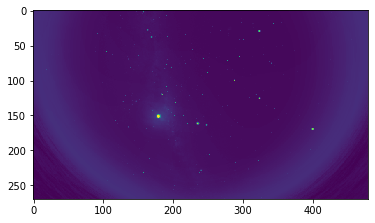

In [7]:
bucket_name='w251-final-project'
file_name='30.00016404896498+-54.75229869627509+2020-07-04T01:00:00.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name,(480,270))
plt.imshow(sample_image)
print(sample_image.shape)

## Prepare the data

### Load the images

In [8]:
#clear out models for memory management purposes
tf.keras.backend.clear_session()

#change this to true to force it to reload from S3 bucket
force_load=True

#check if np arrays have already been saved and load if so
if ((os.path.exists('x.npy'))&(not force_load)):
    print('loading from files')
    X=np.load('x.npy')
    y=np.load('y.npy')

#otherwise go to S3 bucket
else:
    print('loading from S3')
    bucket_name='w251-final-project'
    file_list=get_matching_s3_keys(bucket_name)
    
    #shuffle file list so that if take less than all are distributed.  also makes array randomly shuffled
    random.shuffle(file_list)
    
    s3 = boto3.client('s3')

    #max_files=100000
    max_files=5000
    file_list_length=len(file_list)
    files_to_load=np.minimum(max_files,file_list_length)

    #get images
    print('about to call build_input on',files_to_load,' files')
    dim=(480,270)
    X = build_input(s3,bucket_name,file_list,files_to_load,dim)


    #get labels
    print ('building labels')
    y = build_labels(file_list,files_to_load)
    
    print ('saving arrays so can reload more easily next time through')
#    np.save('x.npy',X)
#    np.save('y.npy',y)

print ('shape of image array:', X.shape)
print ('shape of label list:', y.shape)

loading from S3
about to call build_input on 2000  files
40.95942282451996+-51.83020821780278+2020-07-04T01:00:00.png
loaded: 0
36.15940374658347+-59.12759032707821+2020-07-04T01:00:00.png
45.136982823695334+-59.90261693519367+2020-07-04T01:00:00.png
48.002138390444905+-56.433477602496566+2020-07-04T01:00:00.png
40.45489910391959+-53.38730464395099+2020-07-04T01:00:00.png
40.62635908254629+-54.90337002462074+2020-07-04T01:00:00.png
34.94111563315565+-51.13519096533743+2020-07-04T01:00:00.png
33.82628468958331+-60.01022251574109+2020-07-04T01:00:00.png
31.71127963330229+-58.08567454985092+2020-07-04T01:00:00.png
45.035575845327095+-63.09994478368982+2020-07-04T01:00:00.png
48.69609528675139+-68.51413563827514+2020-07-04T01:00:00.png
49.501937851079745+-55.61393188861055+2020-07-04T01:00:00.png
44.26433098603208+-67.41012076836714+2020-07-04T01:00:00.png
37.33490953947195+-62.475909805407674+2020-07-04T01:00:00.png
48.473520100129235+-66.14381463738073+2020-07-04T01:00:00.png
37.40064365

46.42165694030344+-53.99972805249608+2020-07-04T01:00:00.png
45.54368244869714+-62.028749073205816+2020-07-04T01:00:00.png
37.513450010426055+-67.46753804136657+2020-07-04T01:00:00.png
48.49700546482272+-59.16096061244997+2020-07-04T01:00:00.png
32.57979308934038+-66.96898148538902+2020-07-04T01:00:00.png
34.740231818891615+-62.72962644675108+2020-07-04T01:00:00.png
34.4819005367959+-58.088470852346006+2020-07-04T01:00:00.png
45.48887085061329+-53.90233626888002+2020-07-04T01:00:00.png
35.66570648669331+-66.55290374562418+2020-07-04T01:00:00.png
43.77095990161031+-64.11985389828607+2020-07-04T01:00:00.png
43.620230094121354+-50.745430448539466+2020-07-04T01:00:00.png
36.363827664249925+-60.8836731823358+2020-07-04T01:00:00.png
48.795257182841596+-66.99419613240094+2020-07-04T01:00:00.png
39.46448354760774+-65.03244305893317+2020-07-04T01:00:00.png
36.68488075577112+-51.12718245405262+2020-07-04T01:00:00.png
48.552363581560385+-68.77078849977647+2020-07-04T01:00:00.png
37.59012919939571

36.46714500194861+-55.38180314075041+2020-07-04T01:00:00.png
46.57411624096907+-60.423560194091756+2020-07-04T01:00:00.png
41.50354107323035+-56.96575632535544+2020-07-04T01:00:00.png
47.753720971179405+-60.02301202808071+2020-07-04T01:00:00.png
40.783459699838474+-52.97537262773623+2020-07-04T01:00:00.png
33.97937122413206+-68.20912012821397+2020-07-04T01:00:00.png
43.891665316400385+-59.206463612797336+2020-07-04T01:00:00.png
46.01615440398597+-54.15190799263968+2020-07-04T01:00:00.png
45.545655808053134+-52.92641455447513+2020-07-04T01:00:00.png
33.63904036233022+-52.321295794089636+2020-07-04T01:00:00.png
48.35698161590282+-61.21084713396437+2020-07-04T01:00:00.png
47.724556873568275+-67.29131620534869+2020-07-04T01:00:00.png
34.436105613242646+-69.35479010644701+2020-07-04T01:00:00.png
47.315198969371984+-64.24177711869766+2020-07-04T01:00:00.png
37.31827355462911+-53.02947259886044+2020-07-04T01:00:00.png
35.02469043357673+-58.66809640977715+2020-07-04T01:00:00.png
42.71088893028

36.09571110598078+-62.367468772624974+2020-07-04T01:00:00.png
30.883965463001324+-57.07794917707311+2020-07-04T01:00:00.png
45.50131691249217+-64.69323613123758+2020-07-04T01:00:00.png
44.34107296303732+-56.9428353869512+2020-07-04T01:00:00.png
43.77316892143108+-53.25282089973335+2020-07-04T01:00:00.png
48.518533581889685+-61.76277178819457+2020-07-04T01:00:00.png
45.24839941699126+-52.96685516712548+2020-07-04T01:00:00.png
35.557074131989054+-56.11977385726185+2020-07-04T01:00:00.png
48.33240998825924+-60.02456591599821+2020-07-04T01:00:00.png
38.63089343373903+-55.82650109914003+2020-07-04T01:00:00.png
44.69413695865428+-57.6897734565555+2020-07-04T01:00:00.png
30.13030629081305+-65.40011002060103+2020-07-04T01:00:00.png
42.188948845366504+-62.767416075454534+2020-07-04T01:00:00.png
37.43973711088397+-54.45173620566266+2020-07-04T01:00:00.png
40.02441417882773+-65.76395739689742+2020-07-04T01:00:00.png
39.962919896765726+-66.30462129955475+2020-07-04T01:00:00.png
33.77140673403933+-

38.63673938254583+-57.97668987909069+2020-07-04T01:00:00.png
33.40617467683872+-58.31205585145813+2020-07-04T01:00:00.png
33.63862579977303+-67.06494484170959+2020-07-04T01:00:00.png
42.885299456412255+-65.02252898494606+2020-07-04T01:00:00.png
48.55099780851724+-64.491398081007+2020-07-04T01:00:00.png
48.33372216327153+-64.11273012926796+2020-07-04T01:00:00.png
42.69953465279535+-68.29532524643922+2020-07-04T01:00:00.png
39.09943421707189+-51.68072836412659+2020-07-04T01:00:00.png
35.085920428879156+-69.03425227031656+2020-07-04T01:00:00.png
35.14996139788916+-60.61423941044242+2020-07-04T01:00:00.png
42.9525817988564+-54.24787473869756+2020-07-04T01:00:00.png
48.27759428896396+-67.20464624006323+2020-07-04T01:00:00.png
31.00924338329236+-60.51357647911499+2020-07-04T01:00:00.png
33.29141210452363+-55.21363368996394+2020-07-04T01:00:00.png
48.695077863193475+-51.70125243116724+2020-07-04T01:00:00.png
30.732640900125567+-55.057646542732854+2020-07-04T01:00:00.png
46.8559252499108+-58.5

42.19615449015481+-62.40791163146553+2020-07-04T01:00:00.png
49.01120913661917+-67.00782033914913+2020-07-04T01:00:00.png
38.64084289426056+-52.9279888083088+2020-07-04T01:00:00.png
47.67230501443693+-51.28410283719383+2020-07-04T01:00:00.png
45.116944711976515+-64.28789690415779+2020-07-04T01:00:00.png
49.888077287017005+-57.35534925349529+2020-07-04T01:00:00.png
44.143550273482006+-62.54513260067887+2020-07-04T01:00:00.png
40.01960921561005+-60.343923676242596+2020-07-04T01:00:00.png
39.45972069590048+-63.53767471805287+2020-07-04T01:00:00.png
48.21745632553275+-57.26082747124616+2020-07-04T01:00:00.png
37.50548874046718+-64.74749295932216+2020-07-04T01:00:00.png
46.18462195298565+-63.65352985676857+2020-07-04T01:00:00.png
38.27021746279045+-62.0481688422404+2020-07-04T01:00:00.png
46.20862113388925+-52.19038016430182+2020-07-04T01:00:00.png
43.58694106448888+-59.75907804900356+2020-07-04T01:00:00.png
32.854474464111625+-55.96941452276249+2020-07-04T01:00:00.png
42.68092888870769+-61

34.40979499456751+-61.459592384294346+2020-07-04T01:00:00.png
36.85406112937799+-64.87822625440872+2020-07-04T01:00:00.png
42.17326765219627+-57.79374931231037+2020-07-04T01:00:00.png
30.65654101347524+-50.24769871789873+2020-07-04T01:00:00.png
39.379772295499116+-69.10798461317799+2020-07-04T01:00:00.png
32.555396689802826+-65.16164879739307+2020-07-04T01:00:00.png
35.71793161507645+-68.25365135135351+2020-07-04T01:00:00.png
47.98996705251854+-55.212076314095484+2020-07-04T01:00:00.png
33.433207923636914+-56.75207155142299+2020-07-04T01:00:00.png
42.54950659564386+-65.97305512869826+2020-07-04T01:00:00.png
42.597316742152174+-56.26680160914301+2020-07-04T01:00:00.png
32.660318702064735+-64.75610697605097+2020-07-04T01:00:00.png
43.77175480109139+-56.29466871259252+2020-07-04T01:00:00.png
47.19434588205246+-58.252269602238094+2020-07-04T01:00:00.png
39.314515259836064+-68.4019412194043+2020-07-04T01:00:00.png
46.936268137885364+-59.772406222436786+2020-07-04T01:00:00.png
40.30982194874

38.00025066404094+-66.15985089759639+2020-07-04T01:00:00.png
37.40062181817633+-68.6497855184782+2020-07-04T01:00:00.png
38.495020364540224+-69.82335867847132+2020-07-04T01:00:00.png
44.34474940974316+-59.420854886181935+2020-07-04T01:00:00.png
49.431141756693464+-62.35111677827352+2020-07-04T01:00:00.png
42.930369282452574+-62.62084910800357+2020-07-04T01:00:00.png
36.28304540982803+-66.20255640389699+2020-07-04T01:00:00.png
46.810448769843426+-59.63321578564319+2020-07-04T01:00:00.png
32.09892588875467+-59.194137960053375+2020-07-04T01:00:00.png
42.35074280133472+-62.639222605212964+2020-07-04T01:00:00.png
49.13466683290363+-63.39701563409433+2020-07-04T01:00:00.png
42.40692998968962+-56.590144031935466+2020-07-04T01:00:00.png
42.35388092698675+-64.91403799308276+2020-07-04T01:00:00.png
48.61007008371831+-59.681241161764305+2020-07-04T01:00:00.png
37.77659465110279+-51.98721168915175+2020-07-04T01:00:00.png
32.186346379506375+-68.08097270971575+2020-07-04T01:00:00.png
31.131040792476

35.106871624701455+-65.96589070641228+2020-07-04T01:00:00.png
37.08602032556992+-61.035588877219965+2020-07-04T01:00:00.png
35.74946017676449+-62.23898588119581+2020-07-04T01:00:00.png
40.25099843304763+-63.951038604142184+2020-07-04T01:00:00.png
38.70556386102038+-61.5632194028436+2020-07-04T01:00:00.png
37.805878558227505+-50.08148088065917+2020-07-04T01:00:00.png
44.276673723938046+-53.08474297682156+2020-07-04T01:00:00.png
30.171828866153582+-60.51160507680594+2020-07-04T01:00:00.png
39.80397429696994+-69.98093444531168+2020-07-04T01:00:00.png
38.286427199003704+-58.004952300462605+2020-07-04T01:00:00.png
39.79132087387746+-62.11817064622785+2020-07-04T01:00:00.png
39.863895401276+-51.820340363677445+2020-07-04T01:00:00.png
30.005783454726014+-65.9096578838126+2020-07-04T01:00:00.png
40.15654437856365+-60.17875422845822+2020-07-04T01:00:00.png
36.07321127959209+-62.63792621033084+2020-07-04T01:00:00.png
44.74359695925705+-50.0869376797024+2020-07-04T01:00:00.png
42.941564890098796+

33.80830246573993+-66.16941228523693+2020-07-04T01:00:00.png
32.9050000655507+-68.33164866438297+2020-07-04T01:00:00.png
44.18587577581578+-50.41049508960408+2020-07-04T01:00:00.png
36.56094004989317+-64.82268108332909+2020-07-04T01:00:00.png
31.914821507719417+-59.24770671365766+2020-07-04T01:00:00.png
31.646384237526213+-66.42709773141674+2020-07-04T01:00:00.png
46.50663025571923+-69.84605100261864+2020-07-04T01:00:00.png
48.295770566802105+-50.10180919398505+2020-07-04T01:00:00.png
36.14578543694796+-63.61716476147594+2020-07-04T01:00:00.png
36.2192966581386+-66.53672882973414+2020-07-04T01:00:00.png
32.15183004600327+-51.37082941846013+2020-07-04T01:00:00.png
44.51894053565283+-57.304323994861676+2020-07-04T01:00:00.png
38.40640076994967+-52.760819262445224+2020-07-04T01:00:00.png
32.97250252637291+-57.38560961657753+2020-07-04T01:00:00.png
34.38094298529993+-69.15014352739678+2020-07-04T01:00:00.png
48.38929000261349+-65.86923561298755+2020-07-04T01:00:00.png
31.73378273177115+-55

48.24563683380469+-67.43581073199093+2020-07-04T01:00:00.png
34.43795743708976+-68.51932712088461+2020-07-04T01:00:00.png
40.26327386484792+-65.1619209529426+2020-07-04T01:00:00.png
48.957469084071725+-64.16848997662115+2020-07-04T01:00:00.png
47.603807237120975+-65.52121594590363+2020-07-04T01:00:00.png
42.53010855802927+-64.84432715611607+2020-07-04T01:00:00.png
43.85213959502545+-52.85142639726194+2020-07-04T01:00:00.png
43.58197375240619+-66.44066701762533+2020-07-04T01:00:00.png
38.44402318753435+-68.53909184031794+2020-07-04T01:00:00.png
31.740332632763675+-58.40819238327994+2020-07-04T01:00:00.png
37.47801844261081+-64.1457133604262+2020-07-04T01:00:00.png
39.31092311536404+-64.5291496591204+2020-07-04T01:00:00.png
31.560227959485776+-69.67974520106479+2020-07-04T01:00:00.png
44.931456997887494+-56.07964215478915+2020-07-04T01:00:00.png
40.83694316637452+-52.85373831091524+2020-07-04T01:00:00.png
33.20163994755298+-50.3528437421613+2020-07-04T01:00:00.png
43.70792816205258+-66.6

46.74472404333894+-62.10366397123046+2020-07-04T01:00:00.png
37.753232997454354+-59.19652789898079+2020-07-04T01:00:00.png
45.36765724395603+-62.503299245276736+2020-07-04T01:00:00.png
45.731704843192084+-67.73815895328237+2020-07-04T01:00:00.png
46.96163984778315+-53.018279740932115+2020-07-04T01:00:00.png
42.777030540082635+-54.459781572447966+2020-07-04T01:00:00.png
49.89382588595575+-61.55344867676666+2020-07-04T01:00:00.png
38.080255452639435+-58.49953766021976+2020-07-04T01:00:00.png
38.94326633821417+-58.020901024037904+2020-07-04T01:00:00.png
31.68524450547399+-66.62235190696065+2020-07-04T01:00:00.png
47.827497098009545+-62.37513619167629+2020-07-04T01:00:00.png
33.46547417589638+-56.46395643349376+2020-07-04T01:00:00.png
33.00564909324191+-61.77624644945402+2020-07-04T01:00:00.png
47.7373304501995+-58.55606462685676+2020-07-04T01:00:00.png
49.225874274709994+-52.941359975417505+2020-07-04T01:00:00.png
30.889074657827848+-63.670792046329765+2020-07-04T01:00:00.png
38.364239811

35.73700925441095+-52.650101150142255+2020-07-04T01:00:00.png
34.07401210099874+-58.827637891932845+2020-07-04T01:00:00.png
35.160487789479305+-62.2841267484453+2020-07-04T01:00:00.png
44.36656678452162+-51.30188531841567+2020-07-04T01:00:00.png
39.26441187443355+-64.69082129282688+2020-07-04T01:00:00.png
49.05826114111474+-61.50678642386744+2020-07-04T01:00:00.png
34.62870305173553+-53.45662283753059+2020-07-04T01:00:00.png
37.62021389314345+-68.23628512935801+2020-07-04T01:00:00.png
43.83970828211749+-52.825568198901635+2020-07-04T01:00:00.png
46.31731076965894+-68.63813724437544+2020-07-04T01:00:00.png
38.053902972871754+-68.93358559324214+2020-07-04T01:00:00.png
34.12928553136257+-64.17405002523208+2020-07-04T01:00:00.png
49.200196869477054+-57.97775326352711+2020-07-04T01:00:00.png
46.473623305580674+-56.44781730472567+2020-07-04T01:00:00.png
40.11336875556536+-54.25712562105189+2020-07-04T01:00:00.png
40.933191062170444+-56.84363834645245+2020-07-04T01:00:00.png
46.37744955107225

30.404979385569778+-65.73583321750672+2020-07-04T01:00:00.png
40.925178194935995+-60.180693166351375+2020-07-04T01:00:00.png
39.90952035211234+-60.67901514933184+2020-07-04T01:00:00.png
33.35593369725534+-52.68496220772458+2020-07-04T01:00:00.png
35.509217994342386+-58.9895839443535+2020-07-04T01:00:00.png
42.263536675740255+-53.037011002921204+2020-07-04T01:00:00.png
40.0649483314131+-69.19990711656506+2020-07-04T01:00:00.png
35.59792297606674+-60.918261757122465+2020-07-04T01:00:00.png
40.51673880201409+-52.62858767450287+2020-07-04T01:00:00.png
47.89224961004298+-57.9570084030024+2020-07-04T01:00:00.png
39.93986897819002+-51.99775639036981+2020-07-04T01:00:00.png
43.24686561406808+-58.95279283047578+2020-07-04T01:00:00.png
41.58933479104964+-59.338126333240744+2020-07-04T01:00:00.png
47.10681801648538+-56.76318959304638+2020-07-04T01:00:00.png
40.093864669858604+-54.54244924746861+2020-07-04T01:00:00.png
46.19777688941573+-58.446447986722845+2020-07-04T01:00:00.png
36.67557180952828

30.74444406743191+-50.947717239896356+2020-07-04T01:00:00.png
30.100963302555186+-61.96628025240217+2020-07-04T01:00:00.png
44.02457589205102+-50.28219951660368+2020-07-04T01:00:00.png
37.64834170032744+-61.768171535708916+2020-07-04T01:00:00.png
47.95793990048095+-52.01538396491405+2020-07-04T01:00:00.png
30.516608902097936+-51.897060853239836+2020-07-04T01:00:00.png
36.9375762917734+-57.91618940016284+2020-07-04T01:00:00.png
37.30956013488239+-68.0541521454473+2020-07-04T01:00:00.png
34.210812413137035+-50.06215057673081+2020-07-04T01:00:00.png
39.98052510562782+-68.80071730028251+2020-07-04T01:00:00.png
35.992028743627195+-54.76549737874837+2020-07-04T01:00:00.png
36.56301336071714+-58.05194080885838+2020-07-04T01:00:00.png
42.55118239863603+-51.58197101895965+2020-07-04T01:00:00.png
45.286250008934914+-62.69100436000641+2020-07-04T01:00:00.png
49.90854458029647+-56.02178388345261+2020-07-04T01:00:00.png
41.57911148750311+-63.52808822499131+2020-07-04T01:00:00.png
38.30541885174641+


### Standardize the values

In [9]:
def scale_down(numbers):
    top=max(numbers)
    bottom=min(numbers)
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x-middle for x in numbers]
    revised=[x/number_range*2 for x in revised]
    return revised,top,bottom

def scale_up(numbers,top,bottom):
    middle=(top+bottom)/2
    number_range=top-bottom
    revised=[x*number_range/2 for x in numbers]
    revised=[x+middle for x in revised]
    return revised

In [10]:
#just scaling down without normalizing
y[:,0],toplat,bottomlat=scale_down(y[:,0])
y[:,1],toplong,bottomlong=scale_down(y[:,1])

#y[:,0] = scale(y[:,0])
#y[:,1]=scale(y[:,1])

print (y[:,0].mean(),y[:,0].std())
print (y[:,1].mean(),y[:,1].std())

0.003999809053088997 0.5861410907607695
0.012550348381731363 0.5835241451376693


### Split into test and training sets

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1600, 270, 480)
(1600, 2)
(400, 270, 480)
(400, 2)


### Add channel for CNN

In [12]:
#need to add channel for B&W for CNN
#https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

print(X_train.shape,y_train.shape)
X_train=np.expand_dims(X_train,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape,X_val.shape)

(1600, 270, 480) (1600, 2)
(1600, 270, 480, 1) (400, 270, 480, 1)


## The model

[]

In [13]:
tf.keras.backend.clear_session()

In [14]:
input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [18]:
#model splits into lat long after convolutional layers

input_shape=(270,480,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [19]:
print(model.summary())
#plot_model(model)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 270, 480, 1) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 268, 478, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 134, 239, 64) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 132, 237, 64) 36928       max_pooling2d_8[0][0]            
____________________________________________________________________________________________

### Fit the model

In [20]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=15, batch_size=32)

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 36s 22ms/sample - loss: 0.2004 - regression_lat_loss: 0.1019 - regression_long_loss: 0.0985 - regression_lat_mean_squared_error: 0.1019 - regression_long_mean_squared_error: 0.0985 - val_loss: 0.0151 - val_regression_lat_loss: 0.0080 - val_regression_long_loss: 0.0070 - val_regression_lat_mean_squared_error: 0.0081 - val_regression_long_mean_squared_error: 0.0070
Epoch 2/15
1600/1600 [==============================] - 34s 21ms/sample - loss: 0.0254 - regression_lat_loss: 0.0138 - regression_long_loss: 0.0115 - regression_lat_mean_squared_error: 0.0138 - regression_long_mean_squared_error: 0.0115 - val_loss: 0.0245 - val_regression_lat_loss: 0.0103 - val_regression_long_loss: 0.0141 - val_regression_lat_mean_squared_error: 0.0103 - val_regression_long_mean_squared_error: 0.0142
Epoch 3/15
1600/1600 [==============================] - 34s 21ms/sample - loss: 0.0173 - regression_lat_loss:

### Evaluate model performance

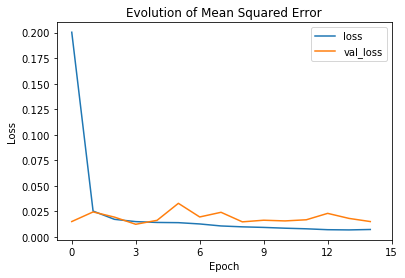

In [21]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [22]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

(30, 50)

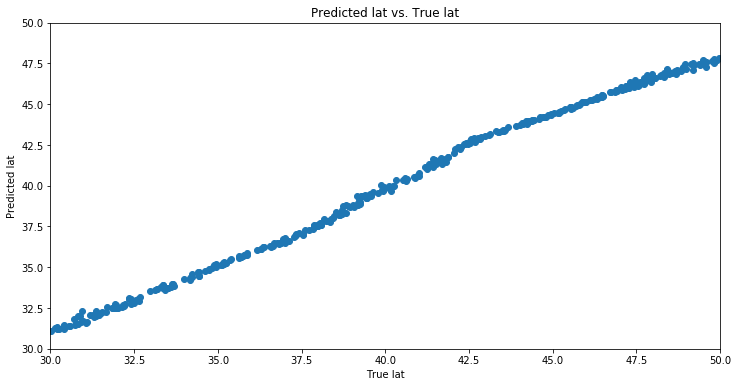

In [23]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
ax.set_xlim(30,50)
ax.set_ylim(30,50)
#draw straight line


(-70, -50)

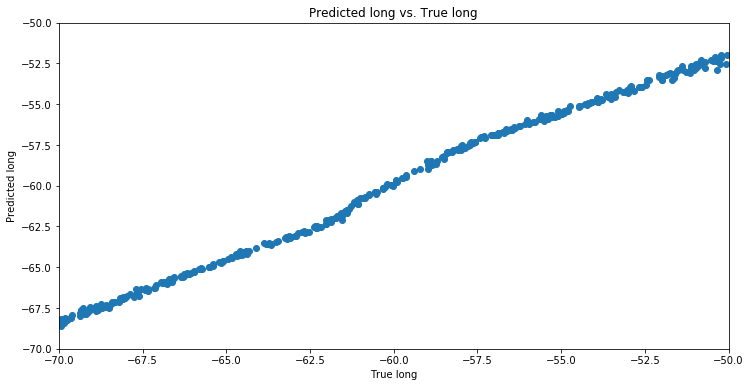

In [24]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
ax.set_xlim(-70,-50)
ax.set_ylim(-70,-50)


### Save Model

In [37]:
model_dir='inference_model'
model.save(model_dir)


INFO:tensorflow:Assets written to: inference_model/assets


In [36]:
test_model=tf.keras.models.load_model(model_dir)


In [44]:
def upload_model(model_dir,bucket_name):
    #s3_client=boto3.client('s3')
    session = boto3.Session()
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(model_dir)+1:], Body=data)

bucket_name='w251-final-project-model'
upload_model(model_dir,bucket_name)

### Feed Forward Dense

In [38]:
#just dense

input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 50176)        0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 528)          26493456    flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 528)          279312      dense_11[0][0]                   
____________________________________________________________________________________________

In [39]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=20, batch_size=128)

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 8s 2ms/sample - loss: 2.0387 - regression_lat_loss: 0.8447 - regression_long_loss: 1.1658 - regression_lat_mean_squared_error: 0.8550 - regression_long_mean_squared_error: 1.1837 - val_loss: 0.6580 - val_regression_lat_loss: 0.3201 - val_regression_long_loss: 0.3377 - val_regression_lat_mean_squared_error: 0.3201 - val_regression_long_mean_squared_error: 0.3379
Epoch 2/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6928 - regression_lat_loss: 0.3413 - regression_long_loss: 0.3514 - regression_lat_mean_squared_error: 0.3413 - regression_long_mean_squared_error: 0.3516 - val_loss: 0.6555 - val_regression_lat_loss: 0.3144 - val_regression_long_loss: 0.3413 - val_regression_lat_mean_squared_error: 0.3143 - val_regression_long_mean_squared_error: 0.3412
Epoch 3/20
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6259 - regression_lat_loss: 0.30

In [40]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

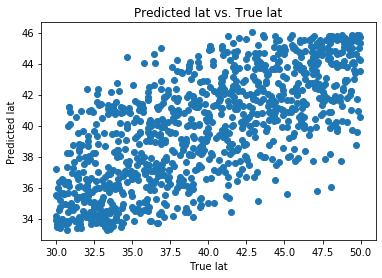

In [41]:
plt.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

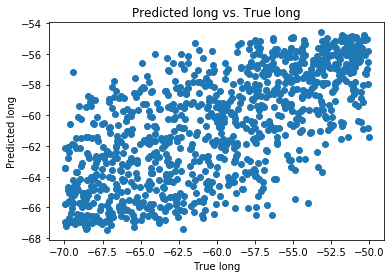

In [42]:
plt.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()

### Things to consider doing:
- don't normalize the lat and long - just scale it DONE
- convert back to lat and long DONE
- set validation batch size to deal with OOM errors (possibly) DONE
- loss weights?
- what is resolution of png files coming in?  are they squares?
- since set wide rectangle, need to make sure entirely at night time
- change angle of view - look more tired horizon?


### Old models

In [ ]:
# Define Input layer(s)
inputShape = (224, 224)
inputs = tf.keras.layers.Input(shape=inputShape)

flatten = tf.keras.layers.Flatten()(inputs)

x=tf.keras.layers.Dense(512,activation='relu')(flatten)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)


# Build and compile model
model_input = inputs
model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])